In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import binned_statistic
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import json
pd.set_option("display.precision", 1)

In [11]:
test_names = ["tabformer_t30", "tabformer_t32a", "tabformer_t32c", "tabformer_t32e"]

### Step 1: Plot Training Log

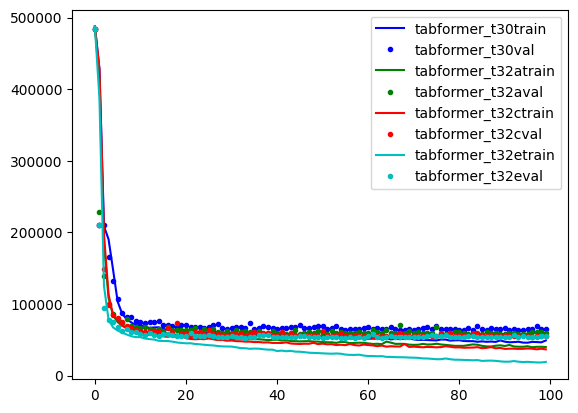

In [12]:
def read_log(log_file):
    data = []
    with open(log_file) as f:
        for line in f:
            data.append(json.loads(line))
    
    return pd.DataFrame.from_dict(data[:-1])
colors = ["b", "g", "r", "c", "m", "y", "k"]
log_files = ["../model_checkpoints/%s/log.txt"%(t) for t in test_names]
log_dfs = [read_log(f) for f in log_files]
for i in range(len(test_names)):
    plt.plot(log_dfs[i]["epoch"], log_dfs[i]["train_loss"], colors[i]+"-", label=test_names[i] + "train")
    plt.plot(log_dfs[i]["epoch"], log_dfs[i]["val_error"], colors[i]+".", label=test_names[i] + "val")
plt.legend()

<BarContainer object of 20 artists>

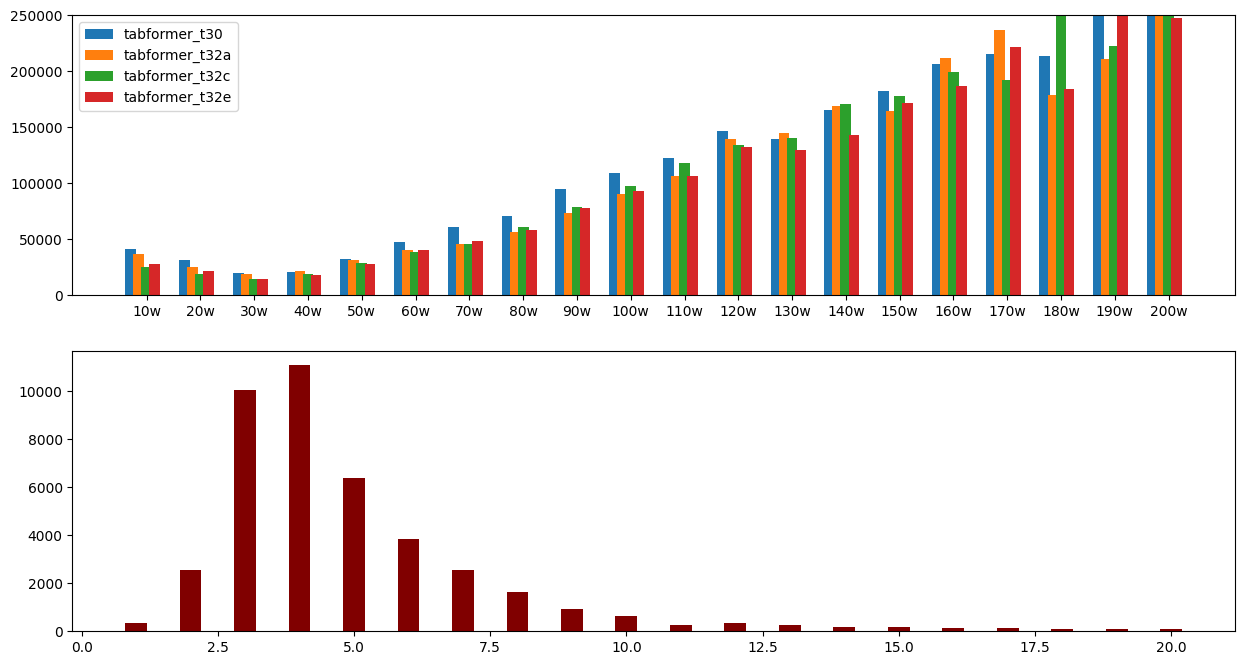

In [13]:
### Step 2: Barplot for the validation prediction 

val_pred_files = ["../model_checkpoints/%s/val_pred.pkl"%(t) for t in test_names]
val_pred_dfs = [pd.read_pickle(f) for f in val_pred_files]


bin_stats, edges, binnumbers = zip(*[binned_statistic(val_pred["true_price"], 
                                             val_pred.apply(lambda x: np.abs(x["true_price"] - x["pred"]), axis=1), 
                                             statistic='median', 
                                             bins=20, 
                                             range=(0, 2e6)
                                         )
                                     for val_pred in val_pred_dfs
                                    ]
                                )

bin_edges = edges[0]
binnumber = binnumbers[0]
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = np.array([(int(_/1e5) + 1) for _ in bin_edges[1:] - bin_width/2])
X = np.array([ "%i0w"%(int(_/1e5) + 1) for _ in bin_edges[1:] - bin_width/2])
cnt = Counter(binnumber)
bin_cnt = [cnt[int(i)] for i in bin_centers]

f, ax = plt.subplots(2, 1)
f.set_figheight(8)
f.set_figwidth(15)


offset_step = 0.6 / len(test_names)
offsets = [(i - len(test_names)/2)*offset_step for i in range(len(test_names))]


for i in range(len(test_names)):
    ax[0].bar(bin_centers + offsets[i], bin_stats[i], width = 0.2, label=test_names[i])

ax[0].set_ylim([0, 250000])
ax[0].set_xticks(bin_centers, X) 
ax[0].legend()
ax[1].bar(bin_centers, bin_cnt, color ='maroon', 
        width = 0.4)

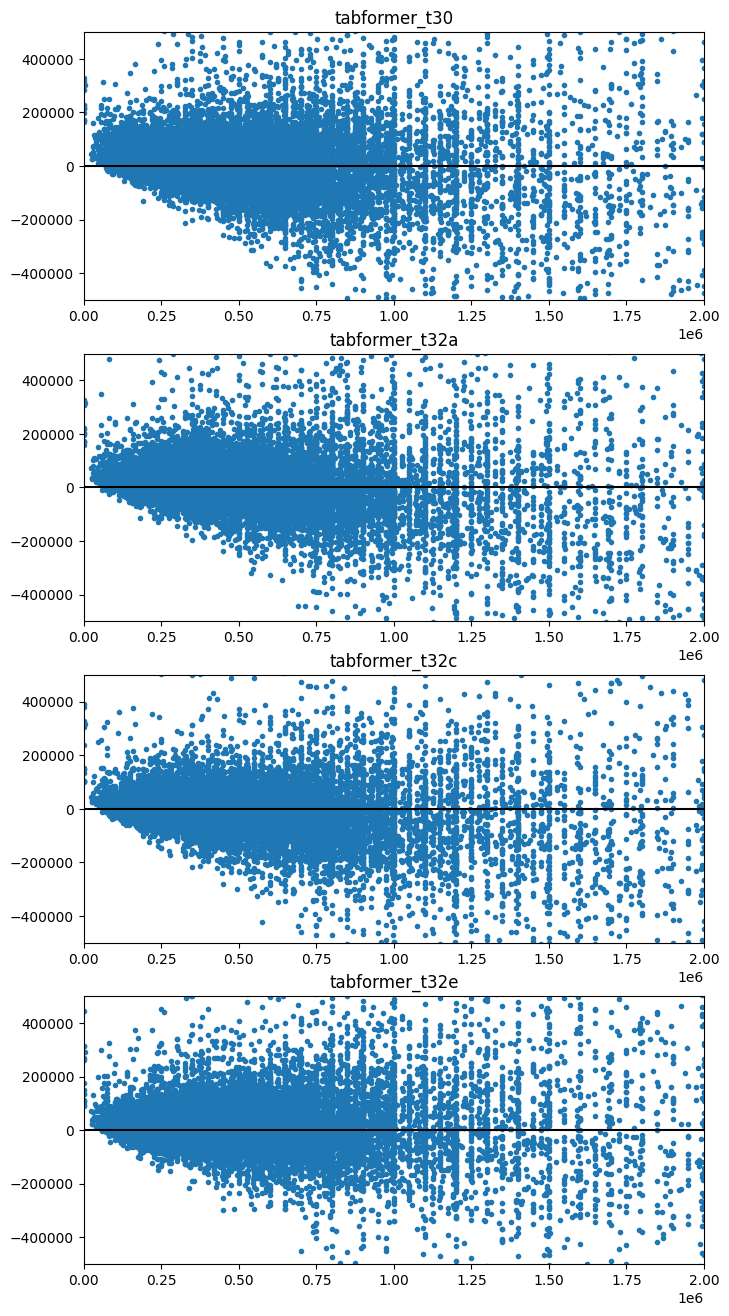

In [14]:
n_test = len(val_pred_dfs)

f, ax = plt.subplots(n_test, 1)
f.set_figheight(4 * n_test)
f.set_figwidth(8)

for i in range(n_test):
    ax[i].plot(val_pred_dfs[i]["true_price"], val_pred_dfs[i]["pred"] - val_pred_dfs[i]["true_price"], ".", label=test_names[i])
    ax[i].plot([0, 2e6], [0, 0], 'k-')
    ax[i].set_xlim([0, 2e6])
    ax[i].set_ylim([-5e5, 5e5])
    ax[i].set_title(test_names[i])

In [63]:
# ##
# [_["true_price"].values for _ in val_pred_dfs]

In [13]:
train_df = df[df["address"].apply(lambda x: x not in val_address)]
val_df = df[df["address"].apply(lambda x: x in val_address)]
len(train_df) + len(val_df), len(df)

(219217, 219217)

In [17]:
from modeling.utils import process_address
train_df["address_key"] = train_df["address"].apply(lambda x: process_address(x))
val_df["address_key"] = val_df["address"].apply(lambda x: process_address(x))

In [18]:
train_df["address_key"].nunique(), len(train_df), val_df["address_key"].nunique(), len(val_df)

(175374, 175374, 30710, 43843)

In [19]:
train_set = set(train_df["address_key"].unique())
val_set = set(val_df["address_key"].unique())
len(train_set.intersection(val_set)), len(train_set), len(val_set)

(7946, 175374, 30710)

In [1]:
import pandas as pd 
import numpy as np
import torch 
import os 
import warnings
import json 
from multiprocessing import Pool

In [2]:
df1 = pd.read_pickle("data/property_structured_12162024_general_desc_features.pkl")

In [3]:
df1.head(2)

,address,address_key,general_desc_roberta_mean_features,general_desc_roberta_cls_features,pool_desc_roberta_mean_features,pool_desc_roberta_cls_features
57,"4513 Refugio Dr, Plano, TX 75024","4513 Refugio Dr, Plano, TX 75024","[-0.05298574, 0.16712712, 0.030846443, -0.0905...","[-0.08189664, 0.081172906, -0.011601419, -0.11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,"1516 Bay Area Blvd P12, Houston, TX 77058","1516 Bay Area Blvd P12, Houston, TX 77058","[-0.04425717, 0.1280026, 0.021496488, -0.11067...","[-0.06736968, 0.065313496, 0.004019822, -0.130...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
